In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
from tqdm import tqdm
import pickle as pkl
import pandas as pd

from ex_simulation import p
from dset import get_dataloader, load_pretrained_model

# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform1d import DWT1d
from utils import get_1dfilts, get_wavefun, dist
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_1dreconstruct, plot_wavefun

# evaluation
from matplotlib import gridspec

# load results

In [2]:
# wavelet params
waves = ["db5", "sym5", "coif2", "const"]
mode = "zero"
J = 4

# result path
path = opj(os.getcwd(), "results")
dirs = [wave + "_saliency_warmstart_seed=1" for wave in waves]
dirs[1] += "_old"
dirs[3] += "_old"

results = []
models = []
for i in range(len(dirs)):
    # load results
    out_dir = opj(path, dirs[i])
    fnames = sorted(os.listdir(out_dir))
    
    results_list = []
    models_list = []
    for fname in fnames:
        if fname[-3:] == 'pkl':
            results_list.append(pkl.load(open(opj(out_dir, fname), 'rb')))
        if fname[-3:] == 'pth':
            if waves[i] == "const":
                wt = DWT1d(wave=waves[0], mode=mode, J=J, init_factor=1, noise_factor=0.0).to(device)
            else:
                wt = DWT1d(wave=waves[i], mode=mode, J=J, init_factor=1, noise_factor=0.0).to(device)
            wt.load_state_dict(torch.load(opj(out_dir, fname)))       
            models_list.append(wt)
    results.append(pd.DataFrame(results_list))
    models.append(models_list)

In [3]:
dics = []
for i in range(len(dirs)):
    # define indexes
    res = results[i]
    mos = models[i]
    lamL1wave = np.array(res['lamL1wave'])
    lamL1attr = np.array(res['lamL1attr'])
    lamL1wave_grid = np.unique(lamL1wave)
    lamL1attr_grid = np.unique(lamL1attr)
    R = len(lamL1wave_grid)
    C = len(lamL1attr_grid)

    # original wavelet
    wt_o = DWT1d(wave='db5', mode=mode, J=J).to(device)

    # collect results
    dic = {'psi':{},
           'wt': {},
           'dist': {},
           'lamL1wave': {},
           'lamL1attr': {},
           'index': {}}

    for r in range(R):
        for c in range(C):
            loc = (lamL1wave == lamL1wave_grid[r]) & (lamL1attr == lamL1attr_grid[c])
            if loc.sum() == 1: 
                loc = np.argwhere(loc).flatten()[0]
                dic['index'][(r,c)] = loc
                wt = mos[loc]
                _, psi, x = get_wavefun(wt)
                d = dist(wt, wt_o)

                dic['wt'][(r,c)] = wt
                dic['psi'][(r,c)] = psi
                dic['dist'][(r,c)] = d        
                dic['lamL1wave'][(r,c)] = lamL1wave_grid[r]
                dic['lamL1attr'][(r,c)] = lamL1attr_grid[c]
    dics.append(dic)

# plot wavelets

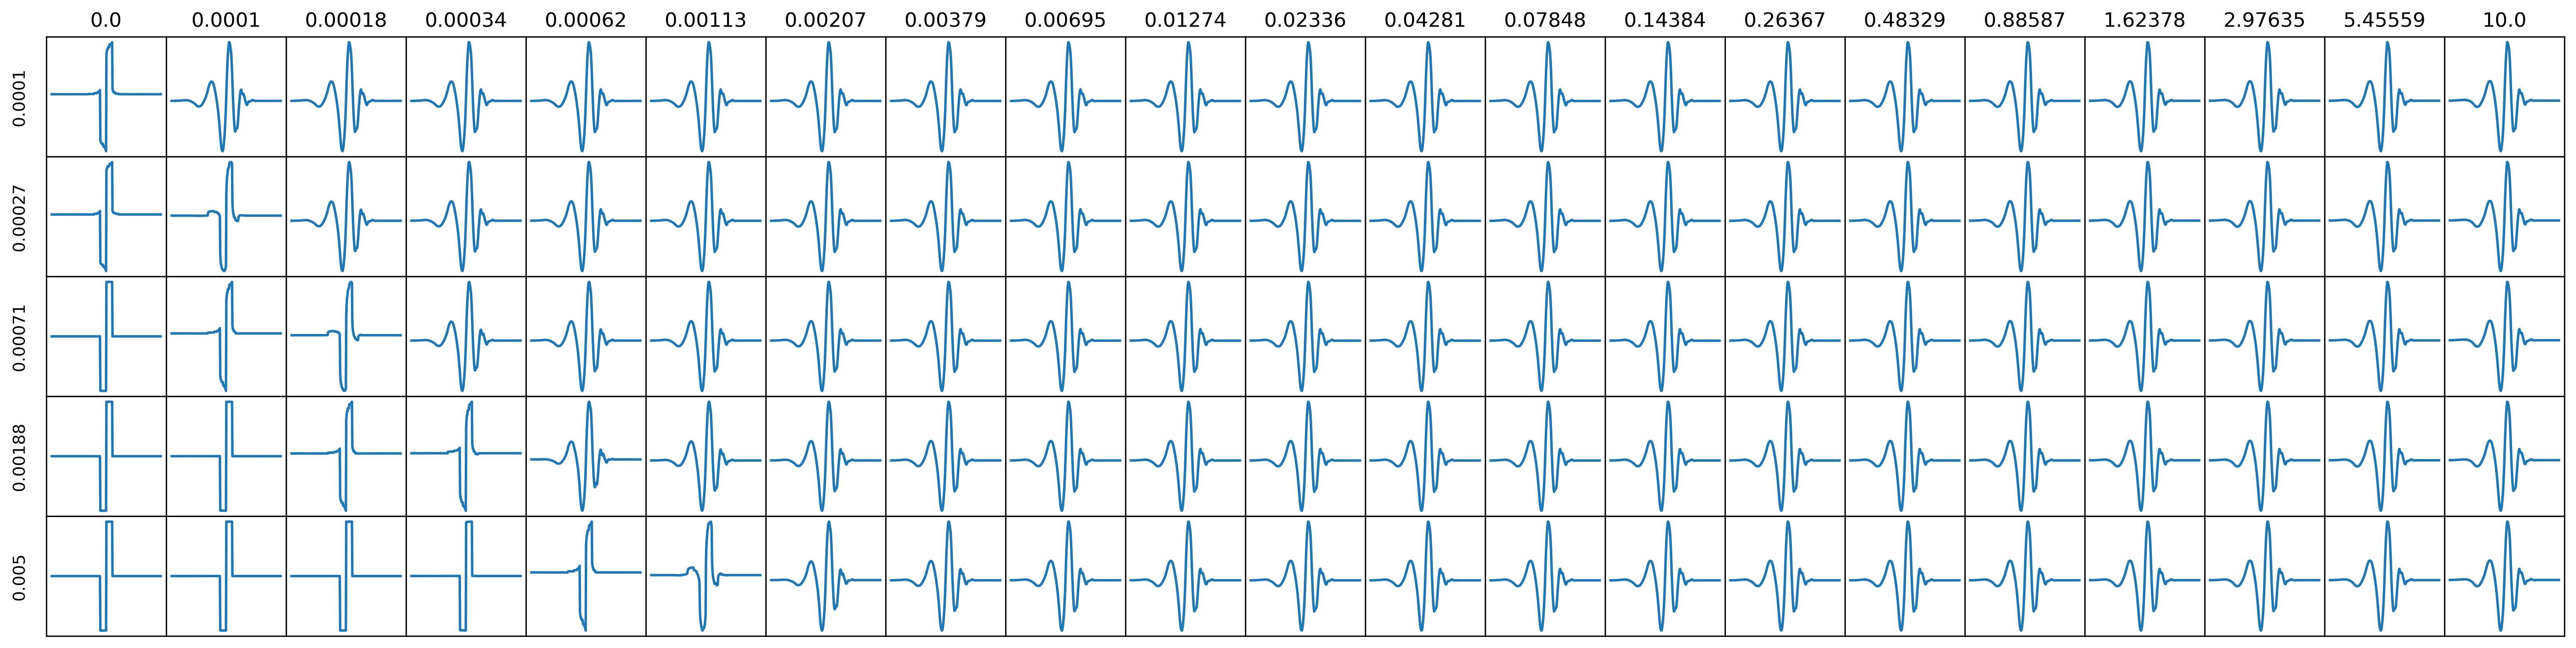

In [13]:
plt.figure(figsize=(C+1, R+1), dpi=300)
gs = gridspec.GridSpec(R, C,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(R+1), bottom=0.5/(R+1), 
         left=0.5/(C+1), right=1-0.5/(C+1))     

index = 0 # select which result to display
lamwaves = np.fromiter(dics[index]['lamL1wave'].values(), dtype=float)
lamattrs = np.fromiter(dics[index]['lamL1attr'].values(), dtype=float)
lamwaves = np.unique(lamwaves)
lamattrs = np.unique(lamattrs)
for r in range(R):
    for c in range(C):
        ax = plt.subplot(gs[r,c])
        ax.plot(x, dics[index]['psi'][(r,c)]) 
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,
            left=False,
            right=False,
            labelbottom=False) 
        if c == 0:
            plt.ylabel(str(lamwaves[r]))
        if r == 0:
            plt.title(str(lamattrs[c]))
plt.show() 


# wavelet with min L1 distance

In [43]:
wlist = []
for i in range(len(dirs)):
    # collect results
    dic = {'bestAWD': {},
           'init': {},
           'x': {},
           'curve': {},
           'lam': {},
           'gam': {}}
    
    min_dist = min(dics[i]['dist'].values())
    r, c = [key for key in dics[i]['dist'] if dics[i]['dist'][key] == min_dist][0]
    wt = dics[i]['wt'][(r,c)]
    phi, psi, x = get_wavefun(wt)
    
    # initialization
    if waves[i] == 'db5':
        torch.manual_seed(p.seed) 
        wt_i = DWT1d(wave=waves[i], mode=mode, J=J, init_factor=1, noise_factor=0.3).to(device)
    elif waves[i] == 'const':
        wt_i = DWT1d(wave=waves[0], mode=mode, J=J, init_factor=0.0, const_factor=0.1).to(device)
    else:
        wt_i = DWT1d(wave=waves[i], mode=mode, J=J, init_factor=1, noise_factor=0.0).to(device)        
    phi_i, psi_i, x_i = get_wavefun(wt_i)  
    
    
    dic['bestAWD'] = psi
    dic['init'] = psi_i
    dic['x'] = x
    
    lam = dics[i]['lamL1wave'][(r,c)]
    gam = [dics[i]['lamL1attr'][(r,c)] for c in range(C)]
    curve = [dics[i]['dist'][(r,c)] for c in range(C)]
    dic['lam'] = lam
    dic['gam'] = gam
    dic['curve'] = curve
    
    wlist.append(dic)

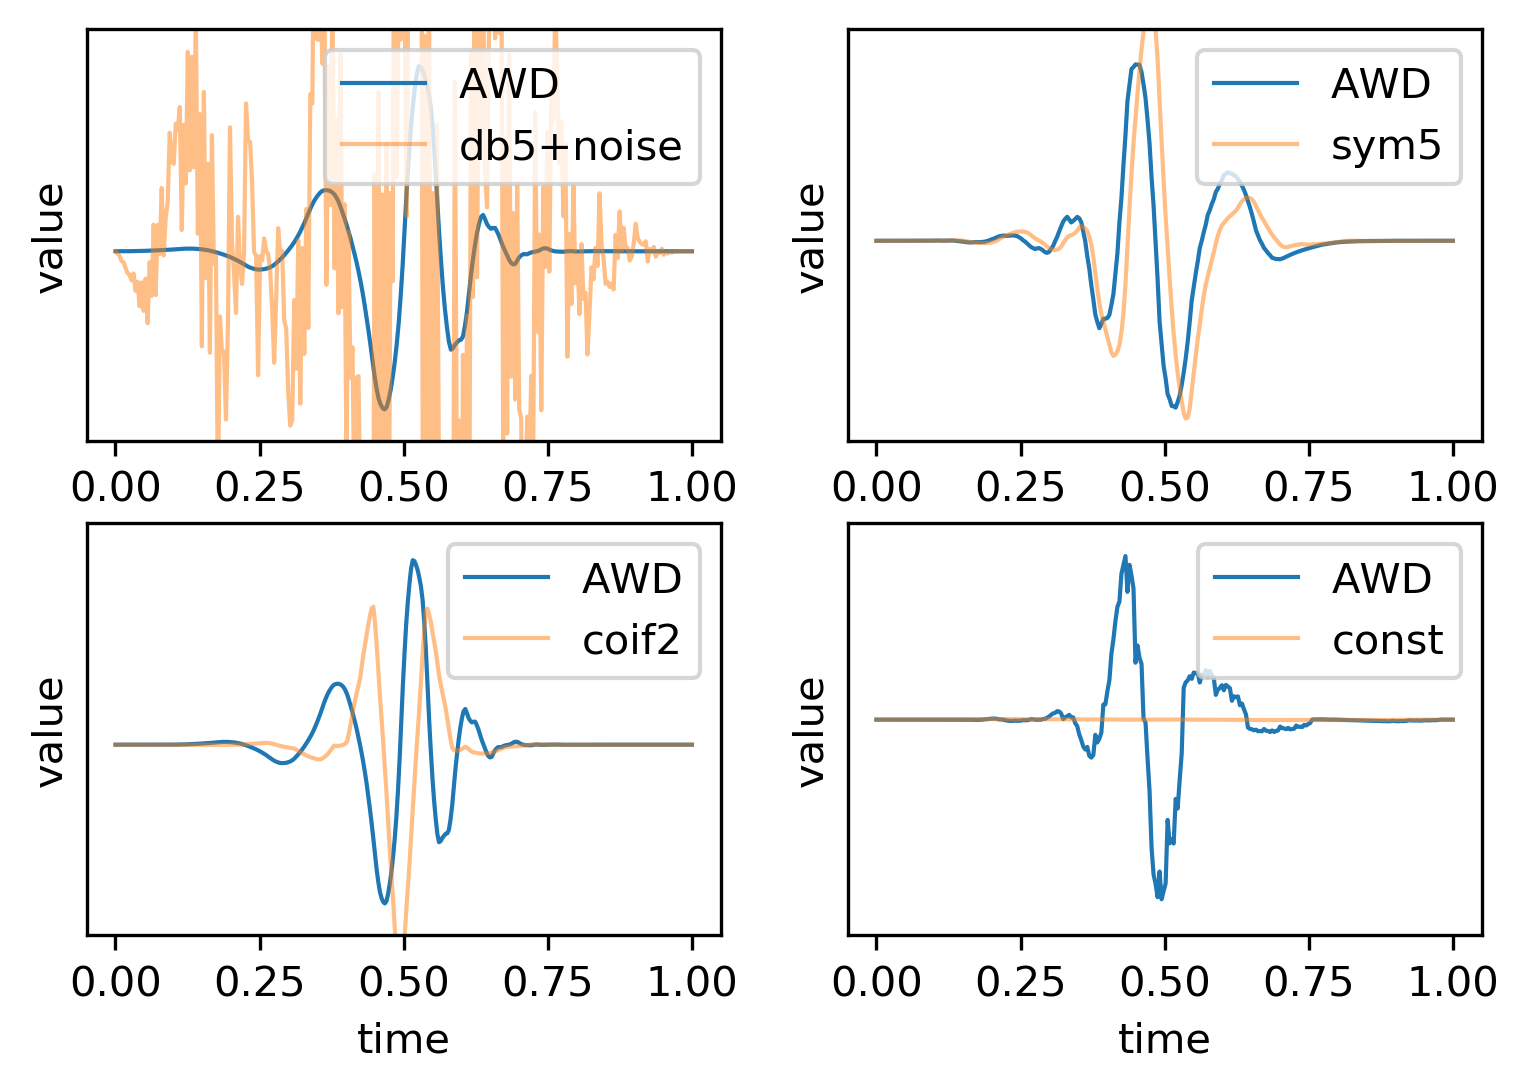

In [37]:
fig = plt.figure(dpi=300)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

ax_00 = fig.add_subplot(spec[0, 0])
idx = 0
psi = wlist[idx]['bestAWD']
psi_i = wlist[idx]['init']
x = wlist[idx]['x']
ax_00.plot(x/np.max(x), psi, label='AWD', linewidth=1)
ax_00.plot(x/np.max(x), psi_i, label='db5+noise', alpha=0.5, linewidth=1)
ax_00.get_yaxis().set_ticks([])
vmin = min(psi)*1.2
vmax = max(psi)*1.2
ax_00.set_ylim([vmin, vmax])
ax_00.set_xlabel('time')
ax_00.set_ylabel('value')  
ax_00.legend(loc='upper right')

ax_01 = fig.add_subplot(spec[0, 1])
idx = 1
psi = wlist[idx]['bestAWD']
psi_i = wlist[idx]['init']
x = wlist[idx]['x']
ax_01.plot(x/np.max(x), psi, label='AWD', linewidth=1)
ax_01.plot(x/np.max(x), psi_i, label='sym5', alpha=0.5, linewidth=1)
ax_01.get_yaxis().set_ticks([])
vmin = min(psi)*1.2
vmax = max(psi)*1.2
ax_01.set_ylim([vmin, vmax])
ax_01.set_xlabel('time')
ax_01.set_ylabel('value')  
ax_01.legend(loc='upper right')

ax_10 = fig.add_subplot(spec[1, 0])
idx = 2
psi = wlist[idx]['bestAWD']
psi_i = wlist[idx]['init']
x = wlist[idx]['x']
ax_10.plot(x/np.max(x), psi, label='AWD', linewidth=1)
ax_10.plot(x/np.max(x), psi_i, label='coif2', alpha=0.5, linewidth=1)
ax_10.get_yaxis().set_ticks([])
vmin = min(psi)*1.2
vmax = max(psi)*1.2
ax_10.set_ylim([vmin, vmax])
ax_10.set_xlabel('time')
ax_10.set_ylabel('value')  
ax_10.legend(loc='upper right')

ax_11 = fig.add_subplot(spec[1, 1])
idx = 3
psi = wlist[idx]['bestAWD']
psi_i = wlist[idx]['init']
x = wlist[idx]['x']
ax_11.plot(x/np.max(x), psi, label='AWD', linewidth=1)
ax_11.plot(x/np.max(x), psi_i, label='const', alpha=0.5, linewidth=1)
ax_11.get_yaxis().set_ticks([])
vmin = min(psi)*1.2
vmax = max(psi)*1.2
ax_11.set_ylim([vmin, vmax])
ax_11.set_xlabel('time')
ax_11.set_ylabel('value')  
ax_11.legend(loc='upper right')

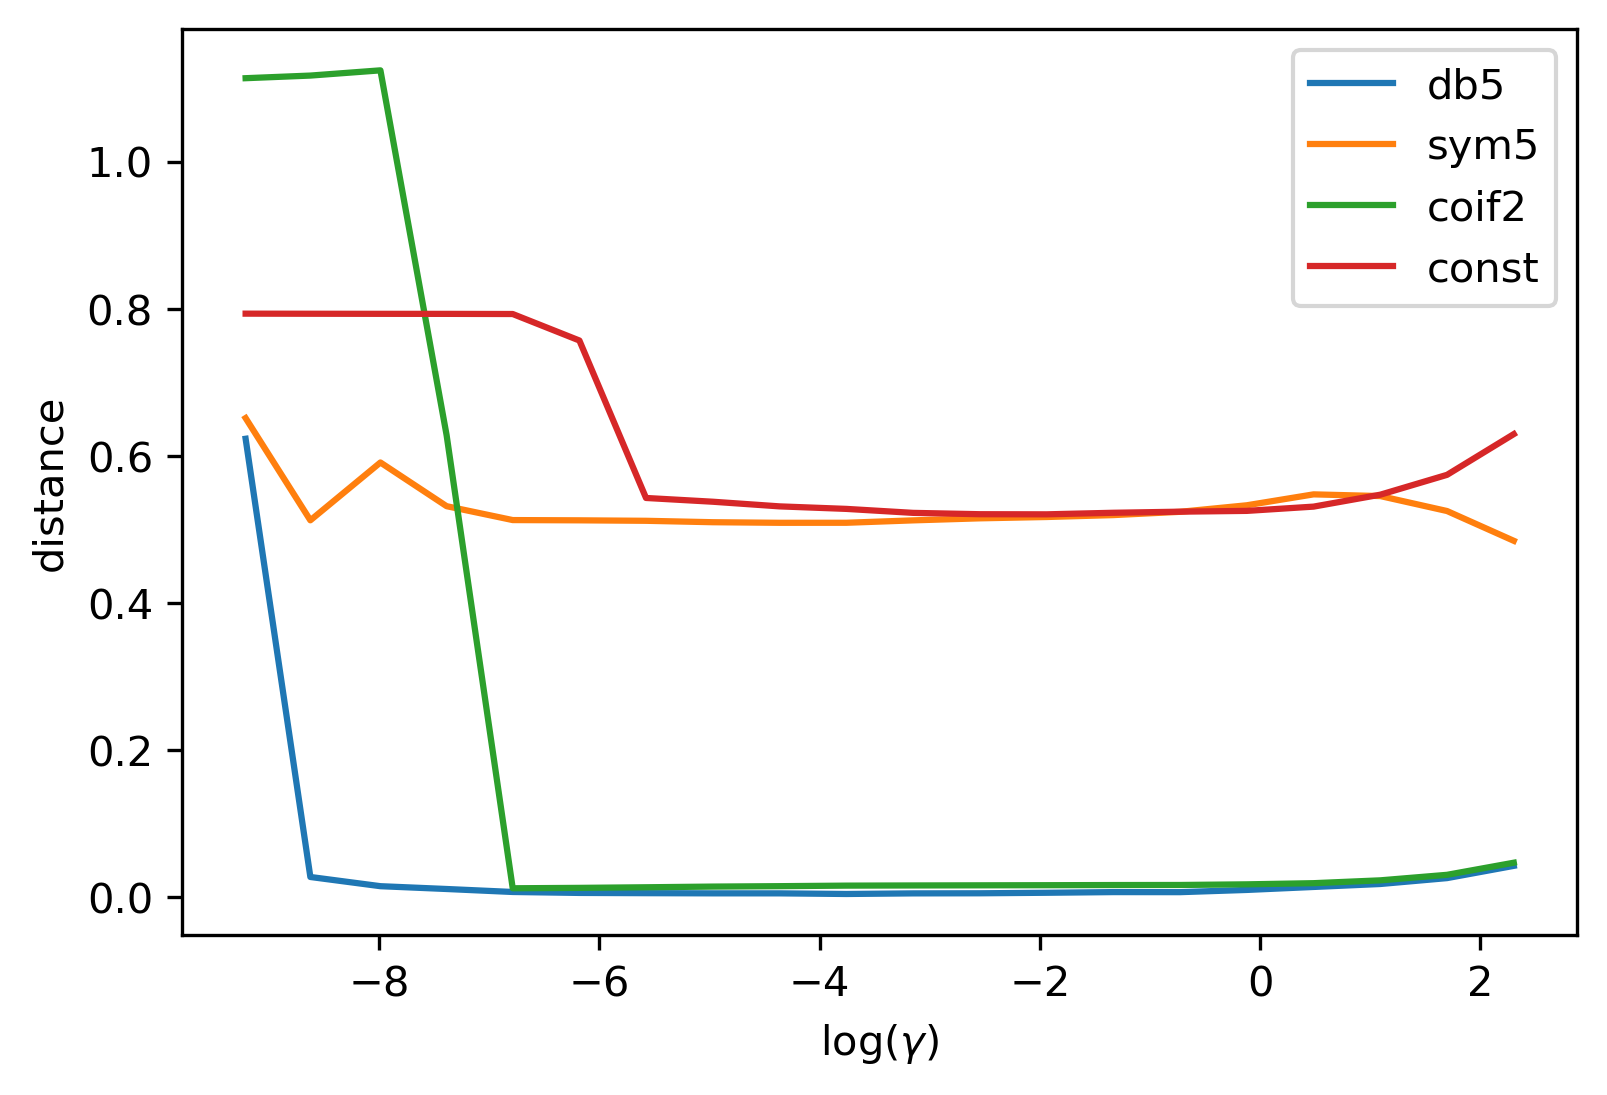

In [49]:
# distance plot
fig = plt.figure(dpi=300)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

ax = fig.add_subplot(spec[0, 0])
for i in range(len(dirs)):
    lam = wlist[i]['lam']
    gam = wlist[i]['gam'][1:]
    curve = wlist[i]['curve'][1:]
    ax.plot(np.log(gam), curve, label='{}'.format(waves[i]))
ax.set_xlabel('$\log(\gamma)$')
ax.set_ylabel('distance')
ax.legend(loc='upper right')   
